# Regressão

Para a parte da regressão do TP escolhemos trabalhar tanto a Regressão Simples quanto a Regressão Multipla e comparamos o desempenho das duas. Usaremos a base de dados limpa na etapa de caracterização.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as ss
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
%matplotlib inline

df_draft = pd.read_csv('../data/clean_nfl_draft.csv',sep=',')
df_draft.head()

,Unnamed: 0,Player_Id,Year,Rnd,Pick,Tm,Player,Pos,Position Standard,First4AV,...,Rush_Yds,Rush_TDs,Rec,Rec_Yds,Rec_Tds,Tkl,Def_Int,Sk,College/Univ,carrer_years
0,0,WinsJa00,2015,1.0,1,TAM,Jameis Winston,QB,QB,13,...,311.0,7.0,0.0,0.0,0.0,0.0,0.0,0,Florida St.,2.0
1,1,MariMa01,2015,1.0,2,TEN,Marcus Mariota,QB,QB,9,...,516.0,4.0,1.0,41.0,1.0,0.0,0.0,0,Oregon,2.0
2,2,FowlDa00,2015,1.0,3,JAX,Dante Fowler,OLB,LB,0,...,0.0,0.0,0.0,0.0,0.0,16.0,0.0,2.5,Florida,2.0
3,3,CoopAm00,2015,1.0,4,OAK,Amari Cooper,WR,WR,9,...,-3.0,0.0,134.0,1970.0,9.0,0.0,0.0,0,Alabama,2.0
4,4,ScheBr00,2015,1.0,5,WAS,Brandon Scherff,T,T,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Iowa,2.0


---
### Regressão Simples

Tentamos definir uma regressão simples baseada nos anos de carreira dos jogadores.

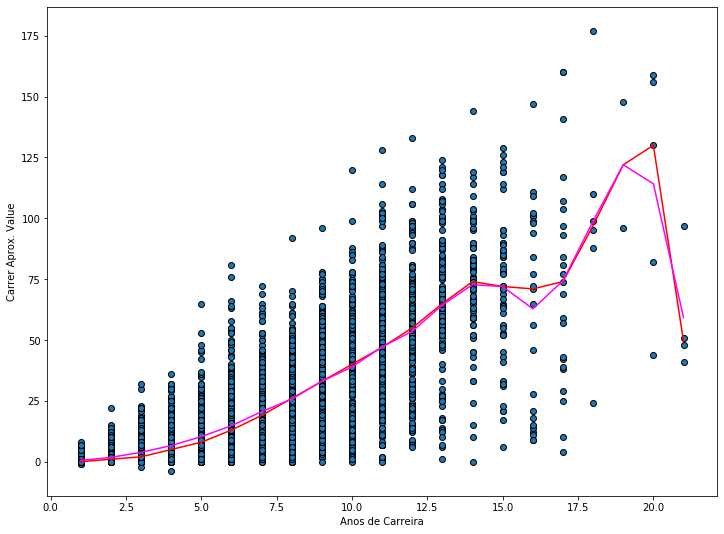

In [3]:
model = df_draft[['CarAV','carrer_years']].groupby('carrer_years').median()
model.head()
x_nn = model.index
y_nn = model.values
model = df_draft[['CarAV','carrer_years']].groupby('carrer_years').mean()
model.head()
x_nn_mean = model.index
y_nn_mean = model.values

x = df_draft['carrer_years'].values
y = df_draft['CarAV'].values
plt.figure(figsize=(12,9))
plt.xlabel("Anos de Carreira")
plt.ylabel("Carrer Aprox. Value")
plt.plot(x_nn, y_nn, color='red')
plt.plot(x_nn_mean, y_nn_mean, color='magenta')
plt.scatter(x, y, edgecolors='k')

Existe uma queda brusca quando os anos de carreira atingem 19 anos, como sabemos que a média dos anos de carreira fira em torno de 5.5 vamos normalizar os dados.

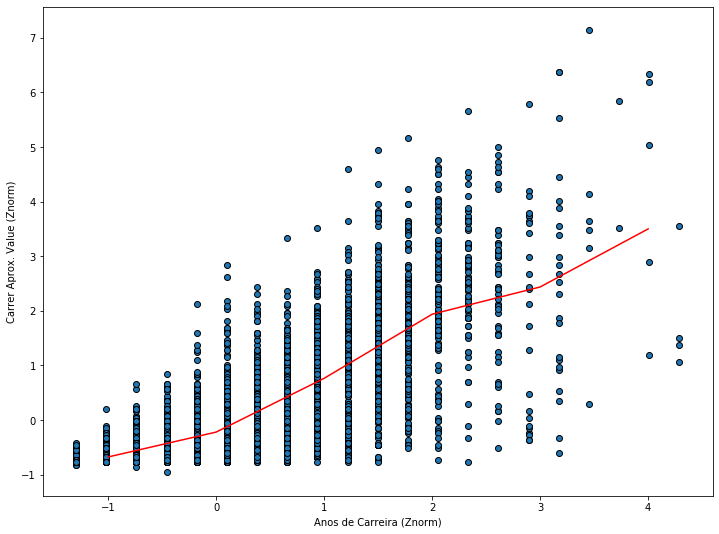

In [4]:
#Usando normalizacao z-score
znorm = df_draft[['CarAV','carrer_years']].copy()
znorm = (znorm - znorm.mean()) / znorm.std(ddof=1)

x = znorm['carrer_years'].copy()
y = znorm['CarAV'].copy()

znorm['carrer_years'] = znorm['carrer_years'].round()
model = znorm.groupby('carrer_years').mean()

x_nn = model.index
y_nn = model.values
plt.figure(figsize=(12,9))
plt.plot(x_nn, y_nn, color='red')
plt.xlabel("Anos de Carreira (Znorm)")
plt.ylabel("Carrer Aprox. Value (Znorm)")
plt.scatter(x, y,edgecolors='k')

Melhor, mas podemos tentar melhorar ainda mais. Vamos usar quadrados minimos e tentar criar uma aproximação mais adequada.

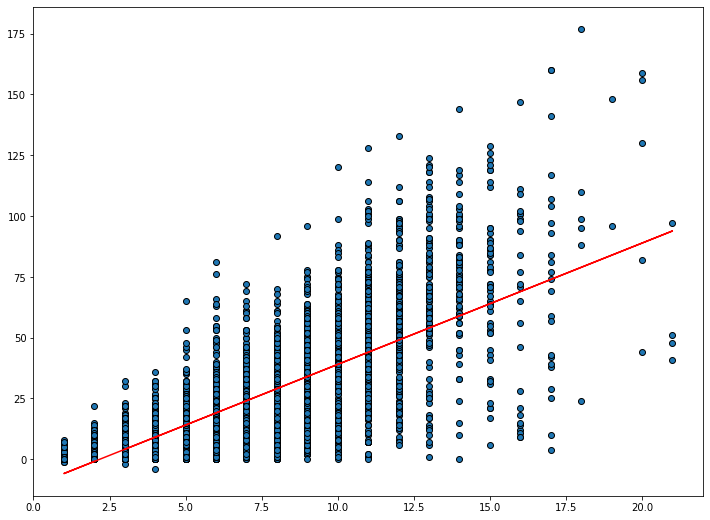

In [5]:
positions = set(df_draft['Position Standard'])
Positions = {}
info = list()
for pos in positions:
    Positions[pos] = df_draft[df_draft['Position Standard'] == pos]

def error(alpha, beta, x, y):
    model = beta * x + alpha
    return y - model

def SSE(alpha, beta, x, y):
    return (error(alpha, beta, x, y) ** 2).sum()

def total_sum_of_squares(y):
    return ((y - y.mean()) ** 2).sum()

def r_squared(alpha, beta, x, y):
    return 1.0 - (SSE(alpha, beta, x, y) /
                  total_sum_of_squares(y))

def least_squares_fit(x, y):
    correlationxy = ss.pearsonr(x, y)[0]
    beta = correlationxy * np.std(y, ddof=1) / np.std(x, ddof=1)
    alpha = np.mean(y) - beta * np.mean(x)
    return alpha, beta

#Usando minimos quadrados para melhor aproximação
x = df_draft['carrer_years'].values
y = df_draft['CarAV'].values
alpha, beta = least_squares_fit(x, y)
y_model = beta * x + alpha
plt.figure(figsize=(12,9))
plt.scatter(x, y, edgecolors='k')
plt.plot(x, y_model, color='red')

In [6]:
#Alpha e beta
print("Alpha: ",alpha,"Beta: ", beta)
print("\nR²: ",  r_squared(alpha, beta, x, y), "R: ", r_squared(alpha, beta, x, y) ** 0.5)
print("\nCorrelação de Pearson: ", ss.pearsonr(x,y)[0])

Alpha:  -10.863602869136233 Beta:  4.986933791547763

R²:  0.6358563577544145 R:  0.7974060181328045

Correlação de Pearson:  0.7974060181328039


---
### Regressão Multipla

Para a regressão multipla separamos os modelos por posição, ja que as features para cada posição são bem diferentes entre si. Chegamos nos resultados demontrados abaixo.

In [7]:
TARGET = 'CarAV'
POSITION_FEATURES = {    
    "QB": ['St','G','First4AV','Cmp','Pass_Att','Pass_Yds','Pass_TD','Pass_Int','Rush_Att','Rush_Yds','Rush_TDs','carrer_years'],
    "WR": ['St','G','First4AV','Rush_Att','Rush_Yds','Rush_TDs','Rec','Rec_Yds','Rec_Tds','carrer_years'],
    "RB": ['St','G','First4AV','Rush_Att','Rush_Yds','Rush_TDs','Rec','Rec_Yds','Rec_Tds','carrer_years'],
    "FB": ['St','G','First4AV','Rush_Att','Rush_Yds','Rush_TDs','Rec','Rec_Yds','Rec_Tds','carrer_years'],
    "TE": ['St','G','First4AV','Rec','Rec_Yds','Rec_Tds','carrer_years'],
    "DE": ['St','G','First4AV','Tkl','Def_Int','Sk','carrer_years'],
    "DT": ['St','G','First4AV','Tkl','Def_Int','Sk','carrer_years'],
    "LB": ['St','G','First4AV','Tkl','Def_Int','Sk','carrer_years'],
    "DB": ['St','G','First4AV','Tkl','Def_Int','Sk','carrer_years'],
}
coeff_dfs = {}
scores = {}
predictions = {}
for position in POSITION_FEATURES.keys():
    test_predict_list = list()
    score_list = list()
    
    X = Positions[position][POSITION_FEATURES[position]].fillna(0).values
    y = Positions[position][TARGET].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)
    lm = LinearRegression()
    model = lm.fit(X_train, y_train)
    prediction = lm.predict(X_test)

    test_predict_list.append(y_test); test_predict_list.append(prediction) 
    predictions[position] = test_predict_list
    
    coeff_df = pd.DataFrame(lm.coef_.T,index = Positions[position][POSITION_FEATURES[position]].columns,columns=['Coefficient'])
    coeff_dfs[position] = coeff_df
    
    score_list.append(metrics.mean_absolute_error(y_test, prediction)) #MAE
    score_list.append(metrics.mean_squared_error(y_test, prediction)) #MSE
    score_list.append(np.sqrt(metrics.mean_squared_error(y_test, prediction))) #RMSE
    scores[position] = score_list


#Multiplots predictions
fig1, axs = plt.subplots(1,9,figsize=(30,4))
fig1.suptitle('Positions Predition Plots')
i = 0
for position in POSITION_FEATURES.keys():
    axs[i].scatter(predictions[position][0], predictions[position][1])
    axs[i].set_title(position)
    axs[i].set(xlabel='Test Value')
    axs[0].set(ylabel='Predicted Value')
    i+=1

ValueError: could not convert string to float: 'Ohio St.'

KeyError: 'DE'

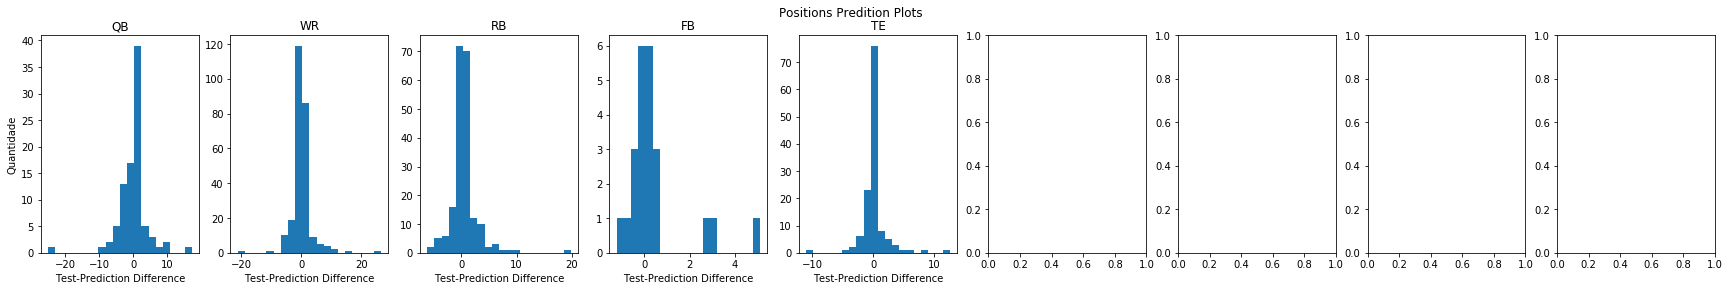

In [8]:
fig1, axs = plt.subplots(1,9,figsize=(30,4))
fig1.suptitle('Positions Predition Plots')
i = 0
for position in POSITION_FEATURES.keys():
    x = predictions[position][0] - predictions[position][1] #Test - Prediction
    axs[i].hist(x,bins=20)
    axs[i].set_title(position)
    axs[i].set(xlabel='Test-Prediction Difference')
    axs[0].set(ylabel='Quantidade')
    i+=1

In [9]:
for position in POSITION_FEATURES.keys():
    print('MAE' + ' -- ' + position + ":", round(scores[position][0],3))
    print('MSE' + ' -- ' + position + ":", round(scores[position][1],3))
    print('RMSE' + ' -- ' + position + ":", round(scores[position][2], 3))
    print('\n')

MAE -- QB: 2.612
MSE -- QB: 19.316
RMSE -- QB: 4.395


MAE -- WR: 1.766
MSE -- WR: 11.91
RMSE -- WR: 3.451


MAE -- RB: 1.437
MSE -- RB: 6.359
RMSE -- RB: 2.522


MAE -- FB: 0.789
MSE -- FB: 2.089
RMSE -- FB: 1.445


MAE -- TE: 1.034
MSE -- TE: 4.415
RMSE -- TE: 2.101




KeyError: 'DE'